In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter

In [2]:
import models
import class_sampling
import train
import metric_utils

In [3]:
NUM_CLASSES = 10
NUM_CLASSES_REDUCED = 2
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
momentum = 0

ratio = (100, 1)

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

nums = (0, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}



simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.BinaryRatio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums,CIFAR=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True) 

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True)

In [ ]:
# SIGMOID 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   


Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.0006931712925434113, AUC: 0.5


Test set: Avg. loss: 0.0006931513249874115, AUC: 0.5


Test set: Avg. loss: 0.0006931595802307129, AUC: 0.5


Test set: Avg. loss: 0.0006931484639644623, AUC: 0.5


Test set: Avg. loss: 0.0006933614611625671, AUC: 0.5


Test set: Avg. loss: 0.000693147212266922, AUC: 0.5


Test set: Avg. loss: 0.0006932352185249329, AUC: 0.5


Test set: Avg. loss: 0.0006932772397994995, AUC: 0.5


Test set: Avg. loss: 0.0006931622624397278, AUC: 0.5


Test set: Avg. loss: 0.0006931504011154175, AUC: 0.5


Test set: Avg. loss: 0.0006931808292865753, AUC: 0.5


Test set: Avg. loss: 0.0006931629478931427, AUC: 0.5


Test set: Avg. loss: 0.0006931658983230591, AUC: 0.5


Test set: Avg. loss: 0.0006932205855846405, AUC: 0.5


Test set: Avg. loss: 0.0006931473016738892, AUC: 0.5


Test set: Avg. loss: 0.0006931476593017578, AUC: 0.5


Test set: Avg. loss: 0.0006934035122394561, AUC: 0.

In [28]:
# SOFTMAX 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes with Softmax \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

RuntimeError: Expected floating point type for target with class probabilities, got Long


Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.002062343716621399, AUC: 0.5000005000000001


Test set: Avg. loss: 0.002150969624519348, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0018572187423706054, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0019018361568450928, AUC: 0.4990005


Test set: Avg. loss: 0.0015238690972328185, AUC: 0.4990005


Test set: Avg. loss: 0.001697654902935028, AUC: 0.4990005


Test set: Avg. loss: 0.001630767047405243, AUC: 0.5000005000000001


Test set: Avg. loss: 0.002055156946182251, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0017298160195350647, AUC: 0.5000005000000001


Test set: Avg. loss: 0.002168138861656189, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0018757094144821167, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0016723748445510865, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0016514639258384705, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0018216487169265747, AUC: 0.50


Test set: Avg. loss: 0.002378443717956543, AUC: 0.499


Test set: Avg. loss: 0.0023392030000686645, AUC: 0.5


Test set: Avg. loss: 0.002293281555175781, AUC: 0.5


Test set: Avg. loss: 0.002569294810295105, AUC: 0.5


Test set: Avg. loss: 0.002317762494087219, AUC: 0.5009999999999999


Test set: Avg. loss: 0.0009159801304340362, AUC: 0.47353599999999996


Test set: Avg. loss: 0.002282113313674927, AUC: 0.499


Test set: Avg. loss: 0.0024804073572158815, AUC: 0.501


Test set: Avg. loss: 0.002556118369102478, AUC: 0.5


Test set: Avg. loss: 0.0021816699504852294, AUC: 0.5


Test set: Avg. loss: 0.0019538766145706177, AUC: 0.5


Test set: Avg. loss: 0.002499666690826416, AUC: 0.5


Test set: Avg. loss: 0.002368769884109497, AUC: 0.5


Test set: Avg. loss: 0.0022419164180755616, AUC: 0.5


Test set: Avg. loss: 0.002331451654434204, AUC: 0.5


Test set: Avg. loss: 0.002477392315864563, AUC: 0.498


Test set: Avg. loss: 0.0024919594526290893, AUC: 0.5


Test set: Avg. loss: 0.002377686858

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0024226115942001343, AUC: 0.5



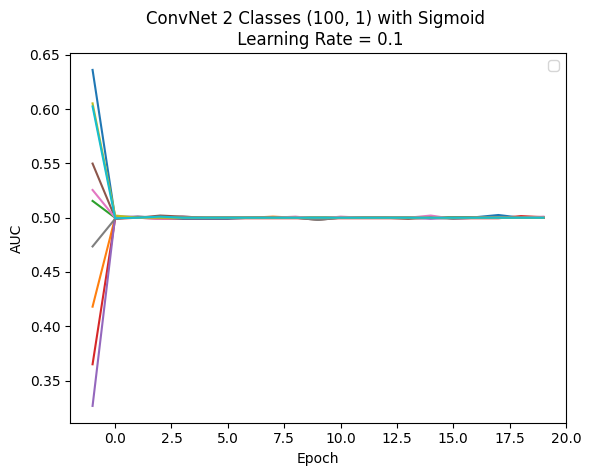


Test set: Avg. loss: 0.008027791500091553, AUC: 0.392356


Test set: Avg. loss: 0.00580462908744812, AUC: 0.49904


Test set: Avg. loss: 0.0012137410044670105, AUC: 0.4304779999999999


Test set: Avg. loss: 0.0015731671452522279, AUC: 0.488896


Test set: Avg. loss: 0.0018343918323516846, AUC: 0.513636


Test set: Avg. loss: 0.002168412446975708, AUC: 0.53145


Test set: Avg. loss: 0.002206195592880249, AUC: 0.5816275


Test set: Avg. loss: 0.001781049072742462, AUC: 0.532629


Test set: Avg. loss: 0.0017826990485191345, AUC: 0.599252


Test set: Avg. loss: 0.001971883952617645, AUC: 0.6590980000000001


Test set: Avg. loss: 0.0017786982655525207, AUC: 0.64876


Test set: Avg. loss: 0.0021869566440582276, AUC: 0.698718


Test set: Avg. loss: 0.0024164912700653076, AUC: 0.609084


Test set: Avg. loss: 0.0018112319707870484, AUC: 0.65176


Test set: Avg. loss: 0.0017779483199119568, AUC: 0.6829200000000001


Test set: Avg. loss: 0.0012685861587524415, AUC: 0.636665


Test set: Avg. loss


Test set: Avg. loss: 0.0009232534766197204, AUC: 0.5005


Test set: Avg. loss: 0.001015794038772583, AUC: 0.5005


Test set: Avg. loss: 0.001106928825378418, AUC: 0.5005


Test set: Avg. loss: 0.001193191885948181, AUC: 0.5014985


Test set: Avg. loss: 0.001273597002029419, AUC: 0.5005


Test set: Avg. loss: 0.0013474547266960144, AUC: 0.5005


Test set: Avg. loss: 0.0014157878160476684, AUC: 0.5005


Test set: Avg. loss: 0.0014783532619476317, AUC: 0.5005


Test set: Avg. loss: 0.001534534752368927, AUC: 0.5005


Test set: Avg. loss: 0.0015869430303573609, AUC: 0.5005


Test set: Avg. loss: 0.0016362206935882568, AUC: 0.5005


Test set: Avg. loss: 0.0016801425218582154, AUC: 0.5005


Test set: Avg. loss: 0.0017207916975021363, AUC: 0.5014985


Test set: Avg. loss: 0.0017592046856880188, AUC: 0.5005


Test set: Avg. loss: 0.0017940574288368225, AUC: 0.5005


Test set: Avg. loss: 0.0018279170393943787, AUC: 0.5005


Test set: Avg. loss: 0.0018595720529556274, AUC: 0.5005


Test set: Av

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0019627081155776977, AUC: 0.770889



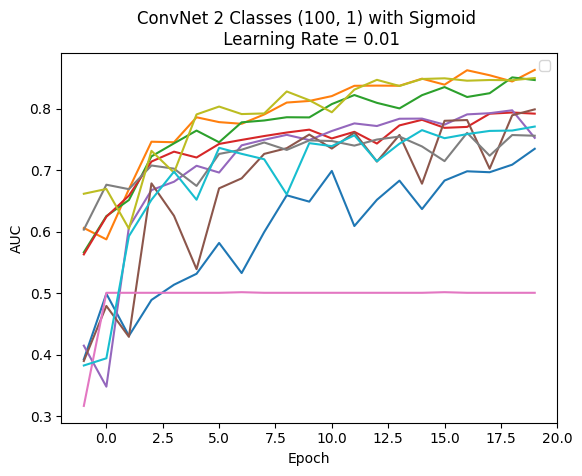


Test set: Avg. loss: 0.0010110598802566529, AUC: 0.332827


Test set: Avg. loss: 0.003166999936103821, AUC: 0.38870299999999997


Test set: Avg. loss: 0.002566297769546509, AUC: 0.48658100000000004


Test set: Avg. loss: 0.0025497665405273436, AUC: 0.550532


Test set: Avg. loss: 0.0027253650426864624, AUC: 0.602903


Test set: Avg. loss: 0.0023512691259384155, AUC: 0.619213


Test set: Avg. loss: 0.0022058777809143065, AUC: 0.6473369999999999


Test set: Avg. loss: 0.002161704421043396, AUC: 0.653044


Test set: Avg. loss: 0.0019353071451187133, AUC: 0.655989


Test set: Avg. loss: 0.002171354651451111, AUC: 0.702771


Test set: Avg. loss: 0.001880911111831665, AUC: 0.707221


Test set: Avg. loss: 0.0019589087367057802, AUC: 0.723571


Test set: Avg. loss: 0.001999002158641815, AUC: 0.731468


Test set: Avg. loss: 0.0017357911467552184, AUC: 0.728793


Test set: Avg. loss: 0.0017520431876182556, AUC: 0.742822


Test set: Avg. loss: 0.0018916257619857788, AUC: 0.7493730000000001


Tes


Test set: Avg. loss: 0.002095265865325928, AUC: 0.7537944999999999


Test set: Avg. loss: 0.0018474889993667603, AUC: 0.76836


Test set: Avg. loss: 0.002185147523880005, AUC: 0.7806630000000001


Test set: Avg. loss: 0.0023704376220703123, AUC: 0.7978130000000001


Test set: Avg. loss: 0.0016240715980529786, AUC: 0.8068500000000001


Test set: Avg. loss: 0.001871028184890747, AUC: 0.8097739999999999


Test set: Avg. loss: 0.0021642338037490844, AUC: 0.7719149999999999


Test set: Avg. loss: 0.0021029975414276125, AUC: 0.7839940000000001


Test set: Avg. loss: 0.0021533591747283937, AUC: 0.791882


Test set: Avg. loss: 0.0018963745832443236, AUC: 0.791858


Test set: Avg. loss: 0.0018755894899368285, AUC: 0.813746


Test set: Avg. loss: 0.0019927606582641603, AUC: 0.8245439999999998


Test set: Avg. loss: 0.0016511749625205993, AUC: 0.8204589999999999


Test set: Avg. loss: 0.0016778504848480225, AUC: 0.837806


Test set: Avg. loss: 0.0017601720690727234, AUC: 0.84154


Test set: Avg.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0018482205867767333, AUC: 0.6421185



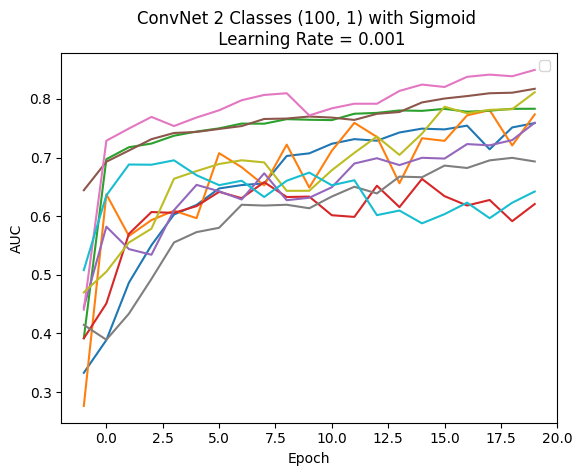


Test set: Avg. loss: 0.000846636176109314, AUC: 0.553688


Test set: Avg. loss: 0.002722360253334045, AUC: 0.508599


Test set: Avg. loss: 0.0027145063877105713, AUC: 0.49623500000000004


Test set: Avg. loss: 0.0032121901512145996, AUC: 0.49005550000000003


Test set: Avg. loss: 0.0034696511030197145, AUC: 0.49638499999999997


Test set: Avg. loss: 0.0035217845439910887, AUC: 0.499582


Test set: Avg. loss: 0.003324193000793457, AUC: 0.49387300000000006


Test set: Avg. loss: 0.0033851776123046875, AUC: 0.506662


Test set: Avg. loss: 0.0032878780364990236, AUC: 0.507952


Test set: Avg. loss: 0.0035710906982421874, AUC: 0.53191


Test set: Avg. loss: 0.003257755160331726, AUC: 0.516913


Test set: Avg. loss: 0.0030339887142181395, AUC: 0.5069950000000001


Test set: Avg. loss: 0.002989039182662964, AUC: 0.50774


Test set: Avg. loss: 0.0030623617172241212, AUC: 0.5166339999999999


Test set: Avg. loss: 0.0028542001247406005, AUC: 0.497398


Test set: Avg. loss: 0.0031705814599990844


Test set: Avg. loss: 0.004298086881637573, AUC: 0.5489609999999999


Test set: Avg. loss: 0.004072943449020386, AUC: 0.545928


Test set: Avg. loss: 0.003961339712142944, AUC: 0.548529


Test set: Avg. loss: 0.0039009802341461184, AUC: 0.548675


Test set: Avg. loss: 0.0037818249464035033, AUC: 0.5505869999999999


Test set: Avg. loss: 0.003997207641601563, AUC: 0.561928


Test set: Avg. loss: 0.003934006571769714, AUC: 0.563855


Test set: Avg. loss: 0.004031757235527038, AUC: 0.5754429999999999


Test set: Avg. loss: 0.0037704503536224367, AUC: 0.569563


Test set: Avg. loss: 0.00325419020652771, AUC: 0.5508665


Test set: Avg. loss: 0.0038833009004592897, AUC: 0.582796


Test set: Avg. loss: 0.0037258379459381105, AUC: 0.583256


Test set: Avg. loss: 0.003596889019012451, AUC: 0.585567


Test set: Avg. loss: 0.0035593619346618653, AUC: 0.592714


Test set: Avg. loss: 0.0009137453436851501, AUC: 0.487454


Test set: Avg. loss: 0.0021062915325164794, AUC: 0.635963


Test set: Avg. lo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0035242501497268677, AUC: 0.42023



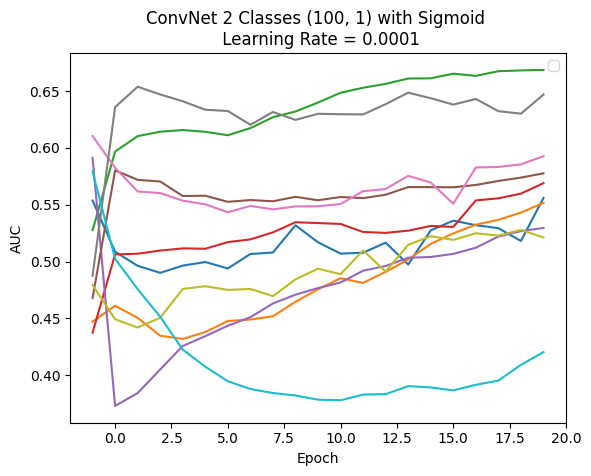


Test set: Avg. loss: 0.002906103849411011, AUC: 0.399255


Test set: Avg. loss: 0.0013121277093887328, AUC: 0.6137859999999999


Test set: Avg. loss: 0.00175262188911438, AUC: 0.621745


Test set: Avg. loss: 0.002014126777648926, AUC: 0.623777


Test set: Avg. loss: 0.0021630499362945556, AUC: 0.6238250000000001


Test set: Avg. loss: 0.0022933838367462157, AUC: 0.623846


Test set: Avg. loss: 0.0023796701431274413, AUC: 0.623128


Test set: Avg. loss: 0.0024521478414535522, AUC: 0.6230899999999999


Test set: Avg. loss: 0.0025420098304748534, AUC: 0.6233


Test set: Avg. loss: 0.002601457715034485, AUC: 0.623146


Test set: Avg. loss: 0.002642536759376526, AUC: 0.622905


Test set: Avg. loss: 0.002647536277770996, AUC: 0.62181


Test set: Avg. loss: 0.0026860344409942627, AUC: 0.621702


Test set: Avg. loss: 0.0027101023197174073, AUC: 0.6216980000000001


Test set: Avg. loss: 0.0027568154335021974, AUC: 0.6221409999999999


Test set: Avg. loss: 0.0027722940444946287, AUC: 0.621276




Test set: Avg. loss: 0.0024521710872650146, AUC: 0.6818379999999999


Test set: Avg. loss: 0.002529175877571106, AUC: 0.6802760000000001


Test set: Avg. loss: 0.002634769797325134, AUC: 0.6789565


Test set: Avg. loss: 0.002684625029563904, AUC: 0.6772440000000001


Test set: Avg. loss: 0.002706258773803711, AUC: 0.674806


Test set: Avg. loss: 0.002778003454208374, AUC: 0.67363


Test set: Avg. loss: 0.002835523843765259, AUC: 0.6733159999999999


Test set: Avg. loss: 0.002892738699913025, AUC: 0.6725335


Test set: Avg. loss: 0.002893472671508789, AUC: 0.6708400000000001


Test set: Avg. loss: 0.00289480197429657, AUC: 0.669852


Test set: Avg. loss: 0.002855384349822998, AUC: 0.6676679999999999


Test set: Avg. loss: 0.002880135893821716, AUC: 0.6672254999999999


Test set: Avg. loss: 0.0028581157922744752, AUC: 0.6654709999999999


Test set: Avg. loss: 0.00289866578578949, AUC: 0.665583


Test set: Avg. loss: 0.002277679920196533, AUC: 0.6168930000000001


Test set: Avg. loss: 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.005476564407348633, AUC: 0.507298



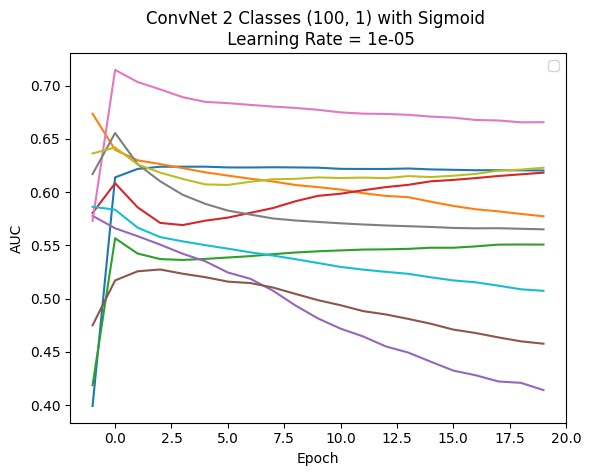


Test set: Avg. loss: 0.002064282298088074, AUC: 0.444684


Test set: Avg. loss: 0.0032827461957931517, AUC: 0.506062


Test set: Avg. loss: 0.004360521078109741, AUC: 0.542949


Test set: Avg. loss: 0.00522196364402771, AUC: 0.566106


Test set: Avg. loss: 0.005876652002334595, AUC: 0.580874


Test set: Avg. loss: 0.006402353048324585, AUC: 0.590817


Test set: Avg. loss: 0.006808501243591308, AUC: 0.5978239999999999


Test set: Avg. loss: 0.007163597822189331, AUC: 0.6033599999999999


Test set: Avg. loss: 0.007461047172546387, AUC: 0.607607


Test set: Avg. loss: 0.007732199192047119, AUC: 0.611315


Test set: Avg. loss: 0.007920188426971436, AUC: 0.61371


Test set: Avg. loss: 0.008109419584274292, AUC: 0.615921


Test set: Avg. loss: 0.00829522180557251, AUC: 0.6180089999999999


Test set: Avg. loss: 0.008473972797393798, AUC: 0.619908


Test set: Avg. loss: 0.0086197509765625, AUC: 0.621279


Test set: Avg. loss: 0.008743274211883544, AUC: 0.6222780000000001


Test set: Avg. loss


Test set: Avg. loss: 0.002971817970275879, AUC: 0.6859120000000001


Test set: Avg. loss: 0.0032322062253952026, AUC: 0.6836930000000001


Test set: Avg. loss: 0.003451590657234192, AUC: 0.6817930000000001


Test set: Avg. loss: 0.003603451371192932, AUC: 0.68032


Test set: Avg. loss: 0.00373664653301239, AUC: 0.678771


Test set: Avg. loss: 0.0038488308191299437, AUC: 0.678138


Test set: Avg. loss: 0.003946543574333191, AUC: 0.6771529999999999


Test set: Avg. loss: 0.004021965026855469, AUC: 0.676122


Test set: Avg. loss: 0.004080554723739624, AUC: 0.6752360000000001


Test set: Avg. loss: 0.004139644622802734, AUC: 0.674507


Test set: Avg. loss: 0.004198835611343384, AUC: 0.673735


Test set: Avg. loss: 0.004246108293533325, AUC: 0.673216


Test set: Avg. loss: 0.004287832021713257, AUC: 0.6727230000000001


Test set: Avg. loss: 0.0043190779685974125, AUC: 0.672238


Test set: Avg. loss: 0.004352328538894654, AUC: 0.6717709999999999


Test set: Avg. loss: 0.004377970933914185, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.006803070306777954, AUC: 0.635427



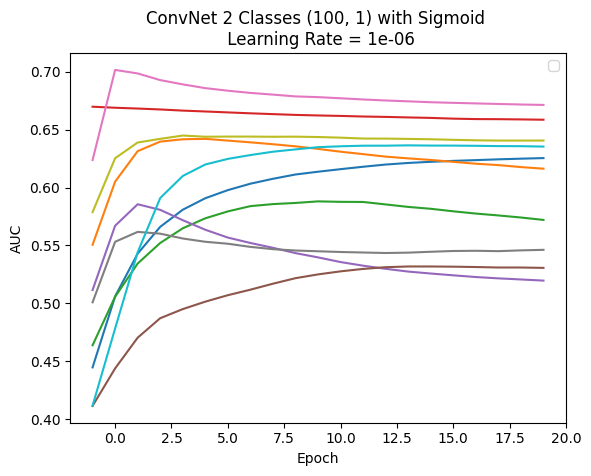


Test set: Avg. loss: 0.0016399760842323303, AUC: 0.6045130000000001


Test set: Avg. loss: 0.001685751497745514, AUC: 0.6044959999999999


Test set: Avg. loss: 0.0017300444841384889, AUC: 0.604247


Test set: Avg. loss: 0.0017716360688209533, AUC: 0.6040490000000001


Test set: Avg. loss: 0.0018106443285942078, AUC: 0.603919


Test set: Avg. loss: 0.001848781704902649, AUC: 0.603578


Test set: Avg. loss: 0.0018867653608322143, AUC: 0.603287


Test set: Avg. loss: 0.0019238693118095397, AUC: 0.6028205


Test set: Avg. loss: 0.001959469139575958, AUC: 0.6024079999999999


Test set: Avg. loss: 0.0019945202469825746, AUC: 0.6018730000000001


Test set: Avg. loss: 0.0020281285047531127, AUC: 0.601578


Test set: Avg. loss: 0.0020603588819503786, AUC: 0.601077


Test set: Avg. loss: 0.002090545654296875, AUC: 0.600722


Test set: Avg. loss: 0.0021203782558441163, AUC: 0.6002720000000001


Test set: Avg. loss: 0.002148703932762146, AUC: 0.599939


Test set: Avg. loss: 0.0021766055822372435,


Test set: Avg. loss: 0.001957572042942047, AUC: 0.7084380000000001


Test set: Avg. loss: 0.002187390446662903, AUC: 0.7141770000000001


Test set: Avg. loss: 0.0024162962436676027, AUC: 0.718927


Test set: Avg. loss: 0.0026564655303955077, AUC: 0.7233550000000001


Test set: Avg. loss: 0.0028909932374954223, AUC: 0.7271475000000001


Test set: Avg. loss: 0.0031242328882217407, AUC: 0.730735


Test set: Avg. loss: 0.003357143402099609, AUC: 0.733874


Test set: Avg. loss: 0.003579241991043091, AUC: 0.7366159999999999


Test set: Avg. loss: 0.0037985241413116457, AUC: 0.739069


Test set: Avg. loss: 0.003992135882377625, AUC: 0.741258


Test set: Avg. loss: 0.004200301885604859, AUC: 0.7433029999999999


Test set: Avg. loss: 0.004392355442047119, AUC: 0.745054


Test set: Avg. loss: 0.004580369472503662, AUC: 0.7467794999999999


Test set: Avg. loss: 0.004745875120162964, AUC: 0.7481949999999999


Test set: Avg. loss: 0.004909946918487549, AUC: 0.7494639999999999


Test set: Avg. loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.00512235951423645, AUC: 0.5362319999999999



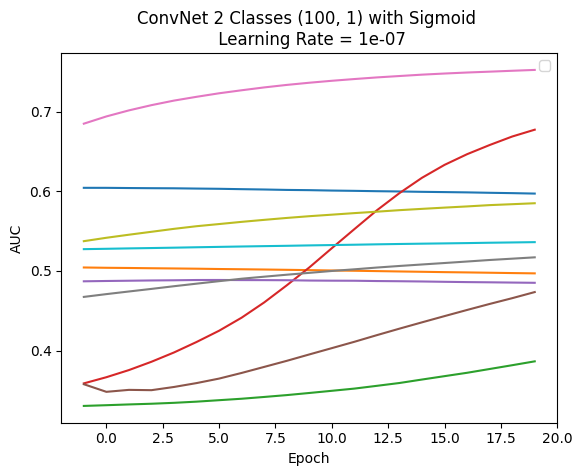

In [6]:
# SIGMOID 2 CLASS RATIO


learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes " + str(ratio) + " with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   

In [ ]:
# SOFTMAX 2 CLASS RATIO


learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes " + str(ratio) + " with Softmax \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   